In [1]:
import numpy as np
rnd_gen = np.random.default_rng(2024)
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
N = 10000
X_gen = rnd_gen.normal(loc=0, scale=1, size=(N, 2))
beta = np.array([1, -1])
Y = X_gen @ beta + rnd_gen.normal(loc=0, scale=1, size=N)

In [3]:
from oncp import ConformalRidgeRegressor

cp = ConformalRidgeRegressor(a=0)

cp.learn_initial_training_set(X_gen[:N-1], Y[:N-1])

In [4]:
def E_ni(X, i):
    zeros = np.zeros_like(X)
    zeros[-1, i] = 1
    return zeros

Y0 = np.append(cp.y, 0)
Y1 = np.append(cp.y, 1)

In [5]:
epsilon = 0.1
Gamma, precomputed = cp.predict(X_gen[-1], epsilon=epsilon, return_update=True, bounds='upper')

In [6]:
l_dic, u_dic = cp._vectorised_l_and_u(precomputed['A'], precomputed['B'])

In [7]:
n = cp.X.shape[0] + 1
int(np.ceil((1 - epsilon)*n))

9000

In [8]:
def partialH(i, precomputed):
    XTXinv = precomputed['XTXinv']
    X = precomputed['X']
    return E_ni(X, i) @ XTXinv @ X.T - X @ XTXinv @ (E_ni(X, i).T @ X + X.T @ E_ni(X, i)) @ XTXinv @ X.T - X @ XTXinv @ E_ni(X,i).T

In [9]:
A = precomputed['A']
B = precomputed['B']
cols = []
for j in range(2):
    H_j_times_Y0 = partialH(j, precomputed) @ Y0
    H_j_times_Y1 = partialH(j, precomputed) @ Y1
    col = [((H_j_times_Y0[-1] - H_j_times_Y0[i])*(B[-1] - B[i]) - (H_j_times_Y1[i] - H_j_times_Y1[-1])*(A[i] - B[-1])) / ((B[-1] - B[i])**2) for i in range(N-1)]
    cols.append(col)
J = np.array(cols).T

In [10]:
x = X_gen[-1]

In [11]:
svd = np.linalg.svd(J)
sigma = svd.S
sigma

KeyboardInterrupt: 

In [ ]:
J[int(np.ceil((1 - epsilon)*n))-1]

array([ 0.56470061, -0.56020346])

In [ ]:
np.linalg.cond(J)

5461.172975794341

In [ ]:
Gamma

(-inf, 2.5896420810975216)

In [ ]:
t = np.array([u for u in u_dic.values()])
t[int(np.ceil((1 - epsilon)*n))-1]

2.5896420810975216

In [ ]:
delta_x = np.array([0,0.1])
(t + J @ delta_x)[int(np.ceil((1 - epsilon)*n))-1]

2.533621735326236

In [ ]:
cp.predict(X_gen[-1] + delta_x, epsilon=epsilon, bounds='upper')

(-inf, 2.4906978706434404)

Plot is not really that nice at the moment, but conceptually it works.

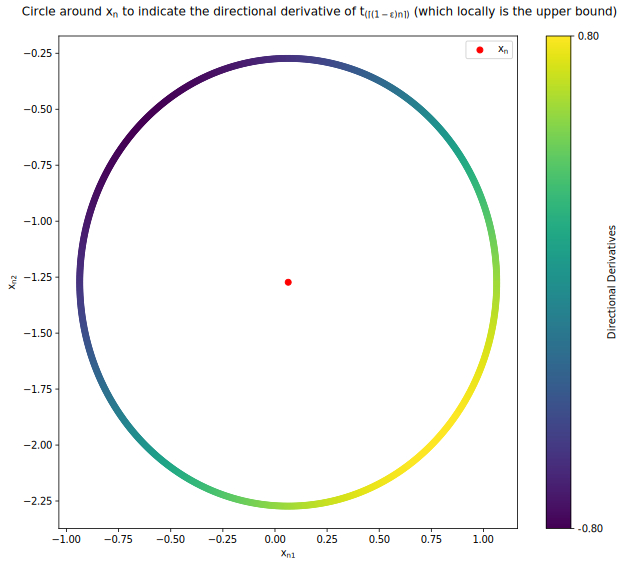

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib_inline.backend_inline import set_matplotlib_formats

# Set the desired output format
set_matplotlib_formats('svg')

k = int(np.ceil((1 - epsilon)*cp.X.shape[0]))-1

cmap = plt.get_cmap('viridis')

# Generate complex points around x
number_of_points = 1000
d_complex = np.array([np.exp(i * 2 * np.pi * 1.j / number_of_points) for i in range(number_of_points)])
points = np.array([[d.real, d.imag] for d in d_complex])

# Compute directional derivatives
directional_derivatives = np.array([J[k] @ p for p in points])

# Normalize the directional derivatives for color mapping
norm = Normalize(vmin=np.min(directional_derivatives), vmax=np.max(directional_derivatives))
colors = cmap(norm(directional_derivatives))

# Create the plot
fig, ax = plt.subplots(figsize=(9, 8))
padding = 0.1
ax.scatter(x[0], x[1], label=r'$x_n$', color='red')
sc = ax.scatter(points[:, 0] + x[0], points[:, 1] + x[1], c=colors)
ax.legend()
# Add a colorbar to reflect the actual data range
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Directional Derivatives')

# Manually set the ticks and labels for the colorbar
min_val = directional_derivatives.min()
max_val = directional_derivatives.max()
cbar.set_ticks([0, 1])  # Set ticks at min and max values
cbar.set_ticklabels([f'{min_val:.2f}', f'{max_val:.2f}'])  # Format tick labels


# Set plot limits
ax.set_xlim(x[0] - 1 - padding, x[0] + 1 + padding)
ax.set_ylim(x[1] - 1 - padding, x[1] + 1 + padding)
ax.set_xlabel(r'$x_{n1}$')
ax.set_ylabel(r'$x_{n2}$')
fig.suptitle(r'Circle around $x_n$ to indicate the directional derivative of $t_{(\lceil(1-\varepsilon)n\rceil)}$ (which locally is the upper bound)')
fig.tight_layout()
fig.savefig('demo.pdf')